In [1]:
import os

from skimage import io
from skimage import color
from skimage import measure, morphology
from skimage import util
from skimage import filters

from scipy import signal

import matplotlib.pyplot as plt

import numpy as np

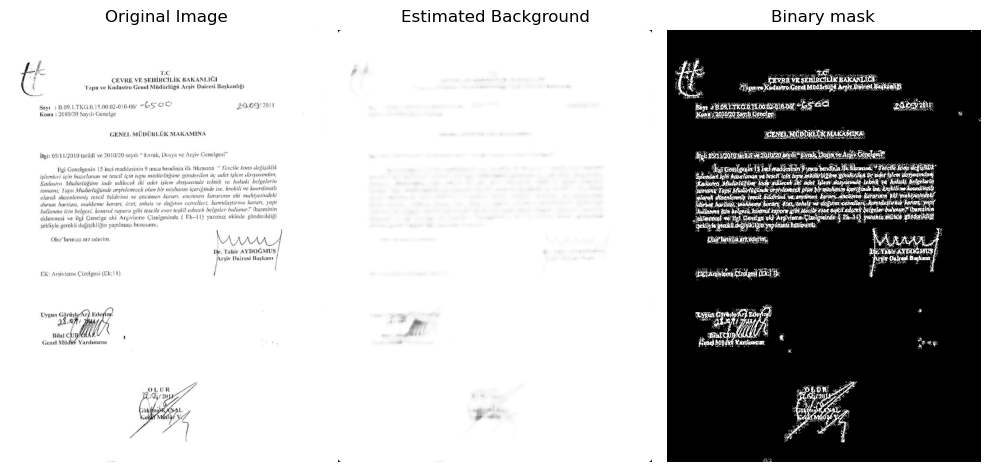

In [2]:
data_path = "C:/Users/Sadek/Documents/GitHub/Project/offline-signature/data"

# Join data_path and the image file name to create a full image path
image_path = os.path.join(data_path + "/input/doc2.jpg")

# Read the image from the specified path
image = io.imread(image_path)

# Convert the image to grayscale
image_gray = color.rgb2gray(image)

# Apply median filtering with a kernel size of 11x11 to reduce noise in the image
bg = signal.medfilt2d(image_gray, (11,11))

# Create a binary mask by subtracting a small value (0.01) from the median-filtered image
mask = image_gray < bg - 0.01

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].imshow(image_gray, cmap='gray')
ax[0].set_title('Original Image')
ax[0].set_axis_off()

ax[1].imshow(bg, cmap='gray')
ax[1].set_title('Estimated Background')
ax[1].set_axis_off()

ax[2].imshow(mask, cmap='gray')
ax[2].set_title('Binary mask')
ax[2].set_axis_off()

plt.tight_layout()
plt.show()

Pixels in `image_gray` that are below the threshold are assigned a value of 1 in the binary mask, while pixels that are equal to or above the threshold are assigned a value of 0. This has the effect of highlighting the areas of the image that are significantly darker than their surrounding background, which often correspond to the objects of interest in the image.

The reason for subtracting **0.1** from the `bg` variable in the second line of code is to adjust the threshold for generating the binary mask. The `bg` variable represents the smoothed image, which can be thought of as an estimate of the background intensity levels in the image. By subtracting **0.1** from `bg`, we effectively **lower the threshold** for detecting foreground objects in the image.

In other words, pixels in the original image that are at least **0.1** units darker than the estimated background in the smoothed image will be considered part of the foreground in the resulting binary mask. This small adjustment to the threshold can help to ensure that the binary mask accurately captures the regions of the image that correspond to the objects of interest, while minimizing the inclusion of noise or other artifacts in the mask.

To some-up, the mask variable is generated using a simple thresholding operation based on the median filter of the grayscale input image.

Next, the `background` argument in this function call indicates the label value assigned to the background pixels, which are those that are not part of any connected component. In this case, a value of **1** is used to indicate that background pixels should be labeled with the integer value **1**.

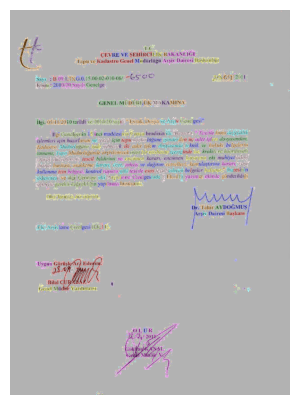

In [3]:
mask_labels = measure.label(mask, background=0)
image_label_overlay = color.label2rgb(mask_labels, image=image)
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the connected components (for debugging)
plt.imshow(image_label_overlay, cmap="gray")
plt.axis('off')
plt.show()

In [4]:
def display_image(image, cmap='gray'):
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.title("Shape: {}".format(image.shape))
    plt.show()

* `SMALL_SIZE_OUTLIER_THRESHOLD`: This parameter sets the minimum area (in pixels) for a connected component in the binary mask to be considered as an outlier and be removed. In the code you provided, this value is set to 10.

* `SMALL_SIZE_OUTLIER_CONSTANT`: This parameter is a constant value that is used to calculate the threshold value for removing small outliers. Specifically, the threshold value is calculated as `(average_area / SMALL_SIZE_OUTLIER_THRESHOLD) * SMALL_SIZE_OUTLIER_CONSTANT + SMALL_SIZE_OUTLIER_OFFSET`. In the code you provided, this value is set to 100.

* `SMALL_SIZE_OUTLIER_OFFSET`: This parameter is an offset value that is added to the threshold value for removing small outliers. In the code you provided, this value is set to 100.

In [5]:
# Define the parameters used to remove small size connected pixel outliers
SMALL_SIZE_OUTLIER_THRESHOLD = 10
SMALL_SIZE_OUTLIER_CONSTANT = 100
SMALL_SIZE_OUTLIER_OFFSET = 100

# Define the parameter used to remove big size connected pixel outliers
BIG_SIZE_OUTLIER_THRESHOLD = 18

# Initialize variables
largest_component_area = 0
total_area = 0
num_large_regions = 0
average_area = 0.0

# Iterate through the regions in the mask
for region in measure.regionprops(mask_labels):
    # Only consider regions with areas greater than SMALL_SIZE_OUTLIER_THRESHOLD
    if (region.area > SMALL_SIZE_OUTLIER_THRESHOLD):
        total_area += region.area
        num_large_regions += 1
        # Check if this region is the largest found so far
        if (region.area > largest_component_area):
            largest_component_area = region.area

# Calculate the average area of the large regions
if num_large_regions > 0:
    average_area = total_area / num_large_regions

# Print the results
print("Largest component area: " + str(largest_component_area))
print("Average area: " + str(average_area))

# Calculate the threshold values for removing outliers
small_size_outlier_threshold = ((average_area / SMALL_SIZE_OUTLIER_THRESHOLD) * SMALL_SIZE_OUTLIER_CONSTANT) + SMALL_SIZE_OUTLIER_OFFSET
big_size_outlier_threshold = small_size_outlier_threshold * BIG_SIZE_OUTLIER_THRESHOLD
print("Small size outlier threshold: " + str(small_size_outlier_threshold))
print("Big size outlier threshold: " + str(big_size_outlier_threshold))

# Remove small size outliers and display the resulting image
pre_version = morphology.remove_small_objects(mask_labels, small_size_outlier_threshold)

Largest component area: 3294
Average area: 196.18333333333334
Small size outlier threshold: 2061.833333333333
Big size outlier threshold: 37112.99999999999


In [6]:
# Apply connected-component labeling to the binary image
pre_mask_labels = measure.label(pre_version, background=0)

# Get the properties of each labeled region, including its area and centroid
pre_regions = measure.regionprops(pre_mask_labels)

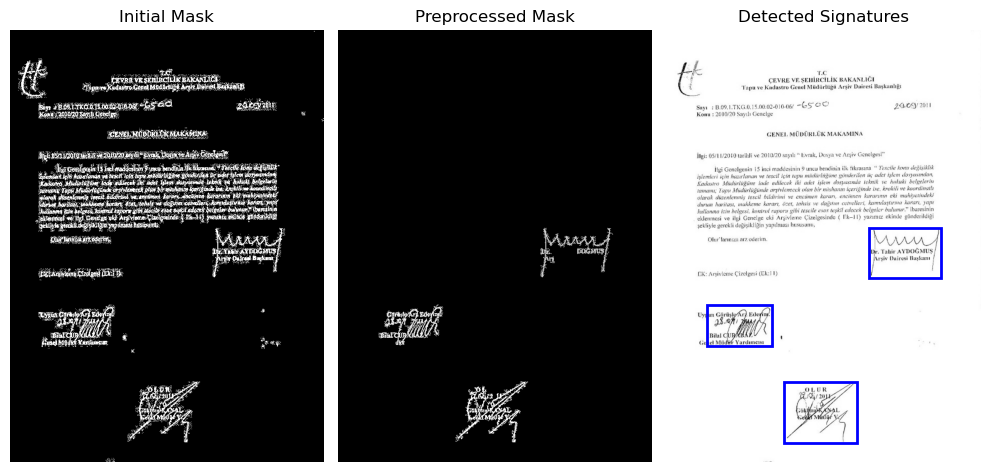

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].imshow(mask, cmap='gray')
ax[0].set_title('Initial Mask')
ax[0].set_axis_off()

ax[1].imshow(pre_version, cmap='gray')
ax[1].set_title('Preprocessed Mask')
ax[1].set_axis_off()

ax[2].imshow(image, cmap='gray')
for region in pre_regions:
    # Extract the bounding box coordinates of the region
    minr, minc, maxr, maxc = region.bbox
    
    # Draw the rectangle on the image
    rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='blue', linewidth=2)
    ax[2].add_patch(rect)
ax[2].set_title('Detected Signatures')
ax[2].set_axis_off()

plt.tight_layout()
plt.show()

Refrence : https://github.com/ahmetozlu/signature_extractor